---

# Topic Modeling (Prepare)

On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifying common themes in customer reviews
* Discovering the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* Part 0: Warm-Up
* Part 1: Describe how an LDA Model works
* Part 2: Estimate a LDA Model with Gensim
* Part 3: Interpret LDA results & Select the appropriate number of topics

# Part 0: Warm-Up
How do we do a grid search? 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle

In [3]:
data = fetch_20newsgroups()

In [4]:
# create X and Y from data
X = data.data
Y = data.target

In [5]:
# we have 20 possible labels for out ML model to predict
n_labels = len(np.unique(Y))

In [6]:
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document. 
    Parameters
    ----------
    text: string or object 
    Returns
    -------
    text: string or object
    """
    # order of operations - apply the expression from top to bottom
    email_regex = "From: \S*@\S*\s?"
    non_alpha = '[^a-zA-Z]'
    multi_white_spaces = "[ ]{2,}"
    text = re.sub(email_regex, "", text)
    text = re.sub(non_alpha, ' ', text)
    text = re.sub(multi_white_spaces, " ", text)
    
    # apply case normalization 
    return text.lower().lstrip().rstrip()

In [7]:
# clean our messy raw data with out clean_data function
X_clean = [clean_data(txt) for txt in X]

In [8]:
# messy data
X[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [9]:
# clean data
X_clean[0]

'where s my thing subject what car is this nntp posting host rac wam umd edu organization university of maryland college park lines i was wondering if anyone out there could enlighten me on this car i saw the other day it was a door sports car looked to be from the late s early s it was called a bricklin the doors were really small in addition the front bumper was separate from the rest of the body this is all i know if anyone can tellme a model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please e mail thanks il brought to you by your neighborhood lerxst'

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, Y)

### GridSearch on Just Classifier
* Fit the vectorizer and prepare BEFORE it goes into the gridsearch

In [11]:
# create tfidf instant
tfidf = TfidfVectorizer(stop_words='english')

# transform data
tfidf.fit(X_train)
dtm_train = tfidf.transform(X_train)
dtm_test = tfidf.transform(X_test)

# why "might" this be a bad idea? DATA LEAKAGE
# in order to avoid data leakage, you fit on the training set
# then yu use .tranform() to create a dtm for the training and test sets
# dtm = tfidf.fit_transform(X_clean)

# create parameter dict
params = {
    "n_estimators": (10, 100),
    "max_depth": (None, 10, 15)
}

# create model instance 
rfc = RandomForestClassifier(random_state=42)

# instantiate a grid search object
gs = GridSearchCV(rfc, params, n_jobs=-1, verbose=1)

# optimize model parameters (i.e. fit)
gs.fit(dtm_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': (None, 10, 15),
                         'n_estimators': (10, 100)},
             verbose=1)

In [12]:
gs.best_score_

0.8321744254566882

In [13]:
# create and tranform a sample text 
sample = [" I love science and dogs and dogs that are sent to space for science."]
sample_vect = tfidf.transform(sample)

# use the model to classify the sample tet 
sample_label = gs.predict(sample_vect)
sample_label

array([14])

In [14]:
data.target_names[14]

'sci.space'

### GridSearch with BOTH the Vectoizer & Classifier

In [15]:
from sklearn.pipeline import Pipeline

# create tfidf instance
v2 = TfidfVectorizer()

# create model instance 
clf = RandomForestClassifier(random_state=42)

# Create a pipline instance using tfidf and your model 
pipe = Pipeline([('vect', v2), ('clf', clf)])

# create parameter dict
p2 = {
    'vect__max_features': (1000, 5000),
    'clf__n_estimators': (10, 20),
    'clf__max_depth': (None, 7)
}

# instantiate a grid search object
gs2 = GridSearchCV(pipe, p2, cv=5, n_jobs=-1, verbose=1)

# optimize model parameters
gs2.fit(X, Y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': (None, 7),
                         'clf__n_estimators': (10, 20),
                         'vect__max_features': (1000, 5000)},
             verbose=1)

In [16]:
gs2.best_score_

0.7622404474706119

In [17]:
# pass a raw text sample into the optimized model in order to classify it
gs2.predict(sample)

array([14])

Advantages to using GS with the Pipe:
* Allows us to make predictions on raw text increasing reproducibility. :)
* Allows us to tune the parameters of the vectorizer along side the classifier. :D 

# Part 1: Describe how an LDA Model works

We are going to focus on a high level of understand for how LDA works, meaning we are going to focus on "what it does" instead of "how it does it". I realize that this may be unsatisfying to some so I've included some resources for folks to student as prerequisites for understanding how LDA works at a mathematical level. 

LDA is a [**Probabilistic Graphical Model (PGM)**](https://en.wikipedia.org/wiki/Graphical_model)

PGM are represented visual with certain symbols. Here's the LDA representation 

![](https://filebox.ece.vt.edu/~s14ece6504/projects/alfadda_topic/main_figure_3.png)

These images are communicating how the hierarchical dependence between probability distributions and their parameters. This is an application of Bayesian Probability - on steroids. 


In order to understand how LDA works, one must first understand how PGM work. If this is something that you're interested in learning more about here are some resources: 

Github repo that has transformed a textbook in a collection of Jupyter Notebooks. This repo is call [**"Bayesian Methods for Hackers"**](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) The cool thing about this repo is that each chapter has the same material covered in several notebooks but each notebook is written in a different python package: **PyMC2, PyMC3, Pyro, and Tensorflow.** So you can even learn a new library if you want or stick to what you know. 

[**Pyro**](https://pyro.ai/) might be the most popular probabilistic programming python library. 

[Your Guide to Latent Dirichlet Allocation](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d)

[LDA Topic Modeling](https://lettier.com/projects/lda-topic-modeling/)

[Topic Modeling with Gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [18]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/pylab/config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [19]:
df = pd.DataFrame({
    'content': data['data'],
    'target': data['target'],
    'target_names': [data['target_names'][i] for i in data['target']]
})
df

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
...,...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,4,comp.sys.mac.hardware
11311,From: westes@netcom.com (Will Estes)\nSubject:...,3,comp.sys.ibm.pc.hardware
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics


In [20]:
# clean messy text data
email_docs = df.content
df['clean_email_docs'] = [clean_data(doc) for doc in email_docs]

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
df.head()

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,target_names,clean_email_docs
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos,where s my thing subject what car is this nntp...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware,guy kuo subject si clock poll final call summa...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware,thomas e willis subject pb questions organizat...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics,joe green subject re weitek p organization har...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space,jonathan mcdowell subject re shuttle launch qu...


In [23]:
# pandarallel doesn't work locally on my machine
# I am going to use mapply instead

# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True, nb_workers=4)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
import mapply
mapply.init(n_workers=3, chunk_size=100, progressbar=True)

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# !python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
%%time
# create our tokens in the form of lemmas 
df['lemmas'] = df['clean_email_docs'].mapply(
    lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)]
)

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 40/40 [03:27<00:00,  5.18s/it]
CPU times: user 615 ms, sys: 318 ms, total: 933 ms
Wall time: 3min 27s


In [30]:
df.head()

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,target_names,clean_email_docs,lemmas
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos,where s my thing subject what car is this nntp...,"[s, thing, subject, car, nntp, post, host, rac..."
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware,guy kuo subject si clock poll final call summa...,"[guy, kuo, subject, si, clock, poll, final, su..."
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware,thomas e willis subject pb questions organizat...,"[thomas, e, willis, subject, pb, question, org..."
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics,joe green subject re weitek p organization har...,"[joe, green, subject, weitek, p, organization,..."
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space,jonathan mcdowell subject re shuttle launch qu...,"[jonathan, mcdowell, subject, shuttle, launch,..."


### The two main inputs to the LDA topic model are the dictionary (id2word) and the corpus.

In [37]:
# Create Dictionary
id2words = corpora.Dictionary(df['lemmas'])

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
counter = 0
for id_, word in id2words.iteritems():
    print(id_, word)
    counter += 1

    if counter == 10:
        break


0 addition
1 body
2 bricklin
3 bring
4 bumper
5 call
6 car
7 college
8 day
9 door
/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# Term Document Frequency
corpus = [id2words.doc2bow(tokens) for tokens in df['lemmas']]

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
# stores (token id, token count) for each doc in the corpus
doc_id = 10

# Human readable format of corpus (term-frequency)
[(id2words[word_id], word_count) for word_id, word_count in corpus[doc_id]]

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('line', 2),
 ('model', 1),
 ('organization', 1),
 ('s', 1),
 ('subject', 1),
 ('thank', 1),
 ('clock', 1),
 ('keyword', 1),
 ('summary', 1),
 ('bit', 1),
 ('distribution', 1),
 ('email', 1),
 ('k', 2),
 ('like', 1),
 ('ll', 1),
 ('opinion', 1),
 ('usa', 1),
 ('worth', 1),
 ('nice', 1),
 ('fix', 1),
 ('hard', 1),
 ('r', 1),
 ('think', 1),
 ('jap', 1),
 ('owner', 1),
 ('accel', 1),
 ('arnstein', 1),
 ('axis', 1),
 ('beemer', 1),
 ('bike', 2),
 ('bronze', 1),
 ('brown', 1),
 ('cmptrc', 1),
 ('computrac', 2),
 ('dod', 1),
 ('duc', 1),
 ('ducati', 2),
 ('expire', 1),
 ('fade', 1),
 ('gmt', 1),
 ('gts', 2),
 ('honk', 1),
 ('inc', 1),
 ('irwin', 3),
 ('leak', 2),
 ('lonestar', 1),
 ('mate', 1),
 ('motor', 1),
 ('oil', 2),
 ('orange', 1),
 ('org', 1),
 ('paint', 1),
 ('pop', 1),
 ('recommendation', 1),
 ('richardson', 2),
 ('run', 1),
 ('sell', 1),
 ('shop', 1),
 ('sit', 1),
 ('st', 1),
 ('stable', 1),
 ('trans', 1),
 ('tuba', 1),
 ('tx', 2),
 ('want', 1)]

# Part 2: Estimate a LDA Model with Gensim

 ### Train an LDA model

In [ ]:
### This cell runs the single-processor version of the model (slower)
# %%time
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            chunksize=100,
#                                            passes=10,
#                                            per_word_topics=True)
# lda_model.save('lda_model.model')
# # https://radimrehurek.com/gensim/models/ldamodel.html

In [46]:
%%time
### This cell runs the multi-processor version of the model (faster)
lda_multicore = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2words,
                                                        num_topics=20, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=2)


lda_multicore.save('lda_multicore.model')
# https://radimrehurek.com/gensim/models/ldamulticore.html

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
CPU times: user 1min 42s, sys: 32.1 s, total: 2min 15s
Wall time: 2min 21s


In [47]:
# this is how to load your trained lda model
from gensim import models
lda_multicore =  models.LdaModel.load('lda_multicore.model')

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### View the topics in LDA model

In [48]:
# display the print_topics from the model 
# built in way to do it
lda_multicore.print_topics()

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.030*"virginia" + 0.028*"ra" + 0.025*"ohio" + 0.020*"state" + 0.019*"edu" + 0.019*"brad" + 0.017*"acs" + 0.015*"magnus" + 0.015*"tim" + 0.014*"ncsu"'),
 (1,
  '0.025*"gun" + 0.011*"kill" + 0.010*"weapon" + 0.010*"fire" + 0.008*"firearm" + 0.007*"day" + 0.007*"crime" + 0.007*"food" + 0.007*"s" + 0.006*"say"'),
 (2,
  '0.059*"x" + 0.021*"file" + 0.019*"window" + 0.011*"program" + 0.011*"version" + 0.010*"image" + 0.009*"use" + 0.008*"s" + 0.008*"r" + 0.008*"available"'),
 (3,
  '0.032*"com" + 0.014*"gay" + 0.013*"homosexual" + 0.013*"man" + 0.012*"stratus" + 0.011*"article" + 0.011*"cramer" + 0.011*"clayton" + 0.009*"optilink" + 0.009*"write"'),
 (4,
  '0.075*"m" + 0.042*"r" + 0.038*"u" + 0.038*"g" + 0.034*"w" + 0.032*"b" + 0.031*"k" + 0.030*"p" + 0.030*"q" + 0.029*"s"'),
 (5,
  '0.023*"god" + 0.011*"s" + 0.010*"christian" + 0.009*"jesus" + 0.008*"people" + 0.008*"believe" + 0.006*"say" + 0.006*"write" + 0.006*"claim" + 0.006*"word"'),
 (6,
  '0.053*"andrew" + 0.040*"cmu" + 0.02

# Part 3: Interpret LDA results & Select the appropriate number of topics

In [51]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_multicore, corpus, id2words)
vis

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.248794  0.014727       1        1  20.626469
16     0.147607 -0.087562       2        1  10.907046
4     -0.105239 -0.360180       3        1   9.288758
5      0.192681  0.080480       4        1   8.095297
19     0.172226  0.057210       5        1   7.785591
2      0.175834 -0.067417       6        1   7.435556
11     0.190223 -0.068970       7        1   6.615196
8      0.080347  0.013800       8        1   5.405195
13    -0.186283 -0.325455       9        1   5.154532
1      0.098947  0.112004      10        1   3.732850
14     0.076892 -0.031082      11        1   3.078012
17     0.056321 -0.056431      12        1   2.718980
12     0.013996  0.084516      13        1   2.239993
7     -0.044733  0.136508      14        1   1.955161
15    -0.124332  0.147696      15        1   1.169218
9     -0.183214  0.006777      16        1   1.148612
3     -0.118008  0.063876      17        1   1.035021
0     -0.173979  0.097976      18        1   0.637934
6     -0.255313  0.071263      19        1   0.615552
18    -0.262767  0.110262      20        1   0.355028, topic_info=         Term          Freq         Total Category  logprob  loglift
5909       ax  62089.000000  62089.000000  Default  30.0000  30.0000
12        edu  18602.000000  18602.000000  Default  29.0000  29.0000
82          m  20340.000000  20340.000000  Default  28.0000  28.0000
269         x  12417.000000  12417.000000  Default  27.0000  27.0000
962         o   6484.000000   6484.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
6083       gp     42.979064     88.090009  Topic20  -5.1176   4.9231
283        cs     78.938422   2666.867776  Topic20  -4.5096   2.1207
2066     math     55.278491    432.099382  Topic20  -4.8659   3.5845
5087  breaker     39.465947     78.862794  Topic20  -5.2028   4.9485
250     point     50.640254   2863.799180  Topic20  -4.9535   1.6056

[1247 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
11962     15  0.975851      abu
1162       3  0.011479       ac
1162       7  0.000957       ac
1162      16  0.987168       ac
8376       1  0.991244     acad
...      ...       ...      ...
2926      10  0.190424     zone
2926      15  0.735125     zone
5199      19  0.993098      zoo
5608      19  0.984700  zoology
2928      14  0.990533     zuma

[3267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 17, 5, 6, 20, 3, 12, 9, 14, 2, 15, 18, 13, 8, 16, 10, 4, 1, 7, 19])

### What is topic coherence?
Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.
A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”


In [52]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2words,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2words, corpus=corpus, texts=df['lemmas'], start=2, limit=22, step=4)

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
CPU times: user 5min 4s, sys: 1min 22s, total: 6min 26s
Wall time: 8min 7s


In [ ]:
# use these values for the plot if compute_coherence_values takes too long to run 
#coherence_values = [0.5054, 0.5332, 0.5452, 0.564, 0.5678, 0.5518, 0.519]

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


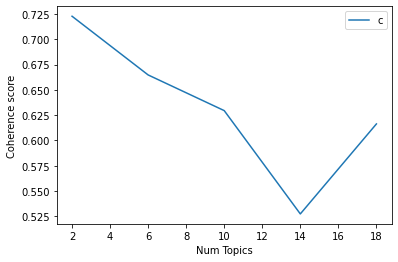

In [54]:
limit=22; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

The higher the coherence score, the better the number of topics. Why?
- The higher coherence score means that top scoring words in each topic are more similar.

In [55]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7227
Num Topics = 6  has Coherence Value of 0.6647
Num Topics = 10  has Coherence Value of 0.6295
Num Topics = 14  has Coherence Value of 0.5274
Num Topics = 18  has Coherence Value of 0.6163
/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
# Select the model and print the topics
optimal_model = model_list[1]
# optimal_model =  models.LdaModel.load('optimal_model.model')
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.015*"s" + 0.011*"t" + 0.007*"people" + 0.005*"say" + 0.004*"right" + '
  '0.004*"know" + 0.004*"write" + 0.004*"think" + 0.004*"state" + 0.004*"edu"'),
 (1,
  '0.017*"x" + 0.010*"line" + 0.009*"edu" + 0.009*"subject" + 0.009*"s" + '
  '0.008*"organization" + 0.006*"com" + 0.006*"use" + 0.006*"t" + '
  '0.005*"post"'),
 (2,
  '0.015*"com" + 0.014*"edu" + 0.013*"t" + 0.011*"line" + 0.011*"subject" + '
  '0.011*"organization" + 0.011*"s" + 0.010*"write" + 0.010*"article" + '
  '0.007*"post"'),
 (3,
  '0.147*"ax" + 0.049*"m" + 0.033*"g" + 0.032*"t" + 0.031*"r" + 0.030*"o" + '
  '0.029*"p" + 0.028*"w" + 0.028*"d" + 0.027*"s"'),
 (4,
  '0.015*"god" + 0.014*"s" + 0.012*"t" + 0.009*"edu" + 0.008*"write" + '
  '0.007*"people" + 0.007*"christian" + 0.006*"subject" + 0.006*"think" + '
  '0.006*"line"'),
 (5,
  '0.016*"edu" + 0.015*"s" + 0.009*"game" + 0.009*"team" + 0.009*"line" + '
  '0.008*"subject" + 0.008*"organization" + 0.008*"t" + 0.007*"year" + '
  '0.007*"win"')]
/Users/keila/.

In [59]:
optimal_vis = pyLDAvis.gensim_models.prepare(model_list[1], corpus, id2words)
optimal_vis

/Users/keila/.local/share/virtualenvs/DS-Unit-4-Sprint-1-NLP-E0pgGHex/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.040155 -0.023861       1        1  26.497921
0     -0.136859 -0.095706       2        1  25.009144
3      0.430161 -0.033435       3        1  13.744459
2     -0.071180  0.048436       4        1  13.241910
4     -0.126981 -0.132278       5        1  11.523039
5     -0.054986  0.236844       6        1   9.983528, topic_info=       Term          Freq         Total Category  logprob  loglift
5909     ax  40782.000000  40782.000000  Default  30.0000  30.0000
82        m  19035.000000  19035.000000  Default  29.0000  29.0000
830       g  10090.000000  10090.000000  Default  28.0000  28.0000
411       r  10673.000000  10673.000000  Default  27.0000  27.0000
962       o  10447.000000  10447.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
480   think    681.302172   5908.517199   Topic6  -5.6908   0.1441
167     new    642.171340   4168.760100   Topic6  -5.7499   0.4337
336     apr    583.217912   4124.924819   Topic6  -5.8462   0.3480
64        d    570.657626  13082.831175   Topic6  -5.8680  -0.8280
82        m    565.180914  19035.035847   Topic6  -5.8776  -1.2127

[460 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
4823      1  0.002437             acs
4823      4  0.833341             acs
4823      5  0.075537             acs
4823      6  0.090157             acs
2205      2  0.997815  administration
...     ...       ...             ...
6539      3  0.995437              yx
3367      1  0.066369               z
3367      2  0.010826               z
3367      3  0.922572               z
6543      3  0.995015              zd

[851 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3, 5, 6])